## Optimizing Conversion Rate for E-Commerce Sales
Vikram Reddy
8/10 - 8/15, 2017

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [2. Transform Data](#Transform-Data)
### [3. Descriptive Statistics](#Descriptive-Statistics)
### [4. Baseline Models](#Baseline-Models)
### [5. Error Analysis](#Error-Analysis)
### [6. Change the Baseline](#Change-the-Baseline)
### [7. Decision Tree](#Decision-Tree)
### [8. Ensemble Methods](#Ensemble-Methods)
### [9. Summary](#Summary)

### Imported Modules
[Top](#Table-of-Contents)

In [39]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sbn

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Load Data
[Top](#Table-of-Contents)

In [4]:
df = pd.read_csv('../data/conversion_data.csv')
df_orig = df.copy()

### Transform Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

In [5]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [6]:
# Create dummy variables for Category values
df_is_country = pd.get_dummies(df['country'])
df_source = pd.get_dummies(df['source'])

# Add columns to dataframe
df[df_is_country.columns] = df_is_country
df[df_source.columns] = df_source

# Drop original columns
df = df.drop('country', axis=1)
df = df.drop('source', axis=1)

In [7]:
df.head()

,age,new_user,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


### Descriptive Statistics
[Top](#Table-of-Contents)

I will plot how different variables are distributed, detecting how the data is skewed or if there is a normal distribution.

Note that only age and total_pages_visited take on non-binary values. These are the two that I will analyze.

(Edit): Based on the confusion matrix, I realize that I should have also analyzed the binary variables. Though they cannot be normally distributed, I can analyze the ratio of 0s to 1s. This would influence how I should calculate a baseline classification. Instead I continue below and using Linear Regression as a baseline.

In [15]:
# Create a data subset to work with
df_stats = df_orig.copy()
df_stats = df_stats.drop(['new_user', 'country', 'source', 'converted'], axis=1)

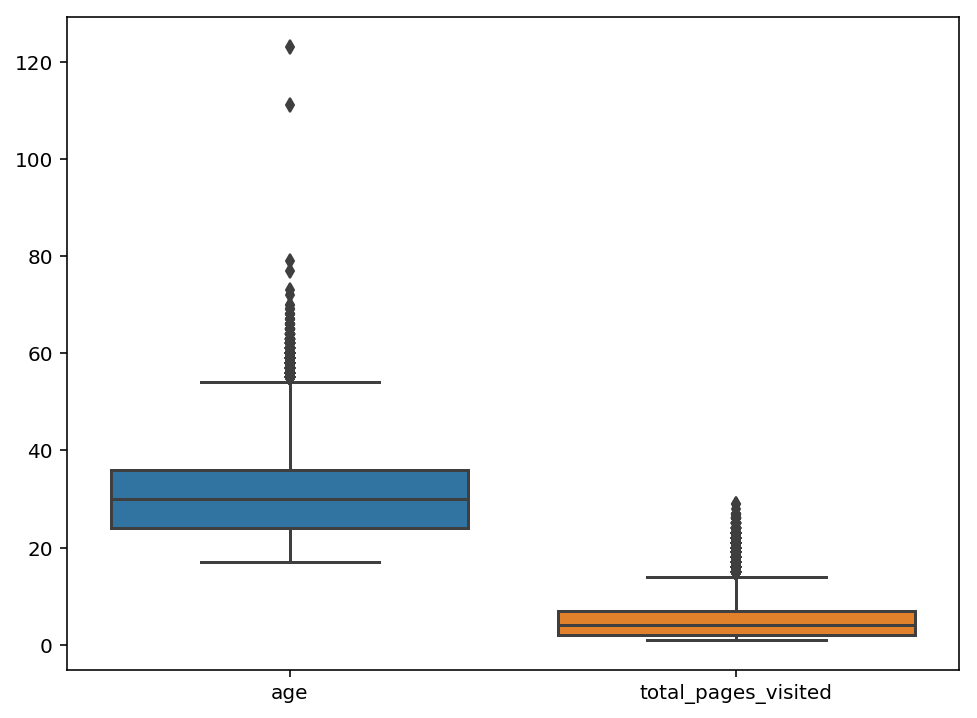

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
sbn.boxplot(data=df_stats)

According to the boxplot, age is normally distributed while the total_pages_visited is skewed to the right.

I will now plot conversions versus the total_pages_visited to see if there are any correlations.

In [23]:
df_stats_of_converted = df_orig.copy()
df_stats_of_converted = df_stats_of_converted.drop(['country', 'new_user', 'source'], axis=1)

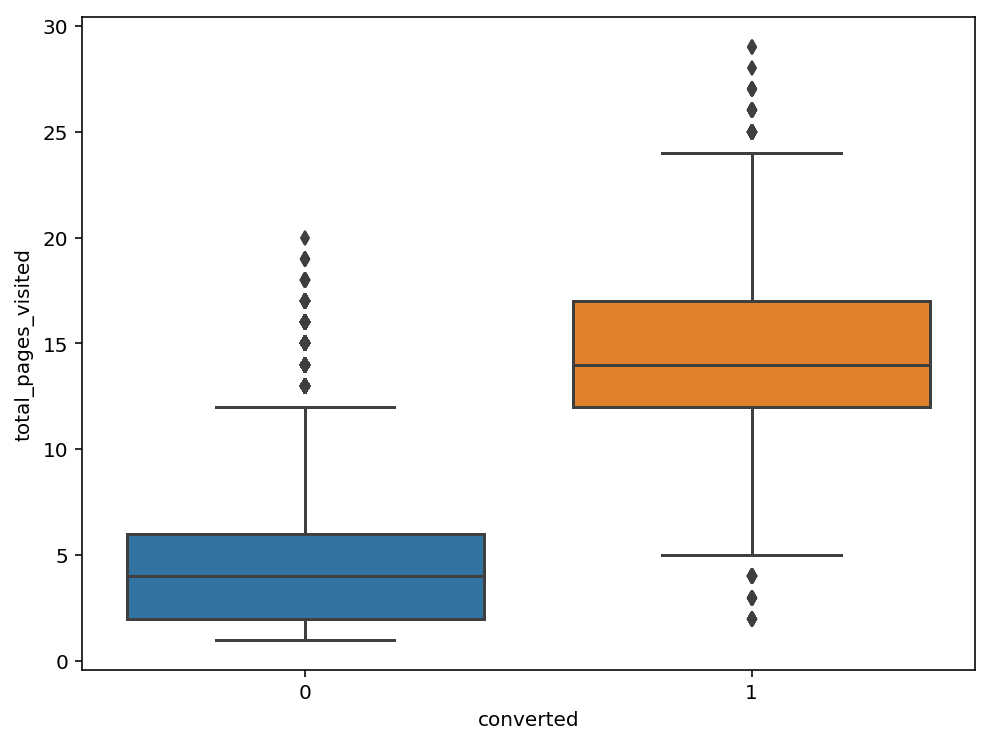

In [104]:
fig, ax = plt.subplots(figsize=(8,6))
sbn.boxplot(x='converted', y='total_pages_visited', data=df_stats_of_converted)

The users who convert look at more pages on average than those who don't convert.

Also, since the median for nonconversions is directly in between the 25 and 75 percentiles, the corresponding number of pages takes on a normal distribution. For conversions, the median is closer to the 25 percentile line, so the data is skewed to the right. In other words, users that visited a lot of different pages end up converting.

### Baseline Models
[Top](#Table-of-Contents)

In [30]:
def get_features(df, label):
    df_features = df.copy()
    df_features = df_features.drop(label, axis=1)
    return df_features
    
def get_labels(df, label):
    return pd.DataFrame(df[label])

def partition_data(features, labels):
    return train_test_split(features, labels, 
                           test_size=0.3,
                           random_state=549)

In [53]:
all_features = get_features(df, 'converted')
all_labels = get_labels(df, 'converted')
train_features, test_features, train_labels, test_labels = partition_data(all_features, all_labels)
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

In [65]:
def train_and_test_model(model):
    print()
    print(model)
    print()
    print('Training model...')
    fitted = model.fit(train_features, train_labels)
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_binary = predicted.round()
    accuracy = accuracy_score(predicted_binary, test_labels)
    print('This model\'s accuracy is {}'.format(accuracy))
    return predicted, accuracy

def get_predictions_and_scores(all_models):
    '''
    Store the predictions and scores in a list of tuples, that can be sorted based on a key. The key is the
    accuracy of each model.
    
    Returns the highest score and corresponding prediction of labels.
    '''
    predictions_and_accuracies = [train_and_test_model(model) for model in all_models]
    return max(predictions_and_accuracies, key=lambda x: x[1])

In [66]:
all_models = [LinearRegression(), LogisticRegression(), BernoulliNB()]
max_score_for_prediction = get_predictions_and_scores(all_models)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training model...
Test the model.
This model's accuracy is 0.9687961205987772

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training model...
Test the model.
This model's accuracy is 0.9856841661395741

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training model...
Test the model.
This model's accuracy is 0.9671832173729706


In [72]:
print('The best model has a score of {:.2f} percent.'.format(max_score_for_prediction[1]*100))

The best model has a score of 98.57 percent.


## Error Analysis
[Top](#Table-of-Contents)

I will plot a confusion matrix to show how many false positives, false negatives, true positives, and true negative I classified using my model.

In [96]:
# Refer to Seaborn Heatmap docs here to select color map:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
def plot_confusion_matrix(cm, labels,
                          title='Confusion matrix',
                         cmap=None):
    
    plt.figure(figsize=(8,8))

    sbn.heatmap(cm,
               annot=True,
               fmt='d',
               linewidths=0.5,
               cmap=cmap)
    
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

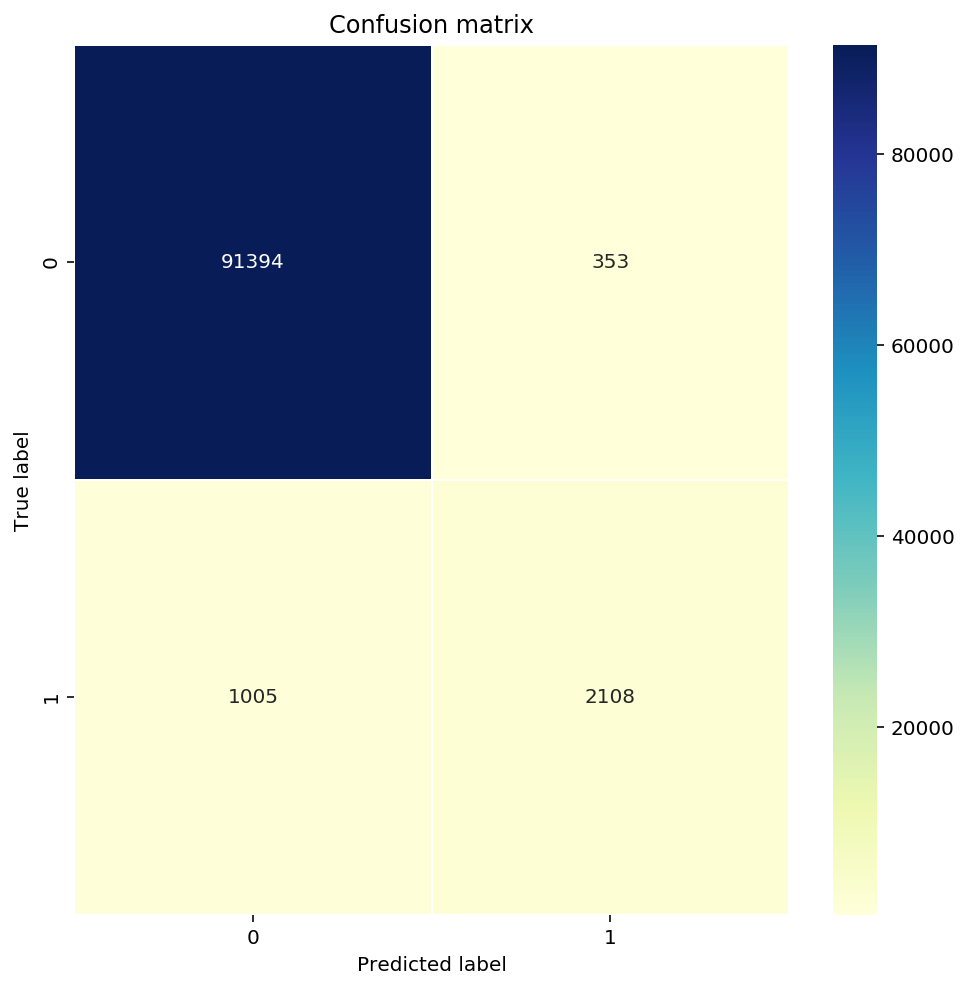

In [97]:
cm = confusion_matrix(test_labels, max_score_for_prediction[0])
plot_confusion_matrix(cm, 
                     labels=['No Conversion','Conversion'],
                     cmap="YlGnBu")

Looking at matrix, I see that most of the correct predictions come from predicting the label '0', or 'no conversion'. Thus, I am dealing with highly skewed data. In order to get a better baseline value, I want to see how a model does when I predict 'no conversion' for everything. 

## Change the Baseline
[Top](#Table-of-Contents)

In [79]:
baseline_accuracy = accuracy_score(np.zeros(len(test_labels)), test_labels)
print('The baseline for predicting no conversions for all instances is {:.2f}.'.format(baseline_accuracy*100))

The baseline for predicting no conversions for all instances is 96.72.


The result is a 96.7% accuracy score.

Next, I will try to use Decision Trees to interpret my models and use Ensemble Methods to optimize the accuracy.

## Decision Trees
[Top](#Table-of-Contents)

In [86]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    print('Fitted model: {}'.format(fitted))
    predicted_labels = fitted.predict(test_features)
    accuracy = accuracy_score(predicted_labels, test_labels)
    print('The accuracy for the decision tree classifier is {}'.format(accuracy*100))
    return fitted

def decision_tree():
    return run_model(DecisionTreeClassifier(max_leaf_nodes=9))

In [87]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=9, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The accuracy for the decision tree classifier is 98.47459413873077


In [89]:
feature_names = all_features.columns
label_names = all_labels.columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
                           # check to see if I need to dummy variablize the labels before
                           # running Decision Tree
               class_names=['no conversion', 'conversion'],
               filled=True, rounded=True,
               special_characters=True)
#graph = graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)

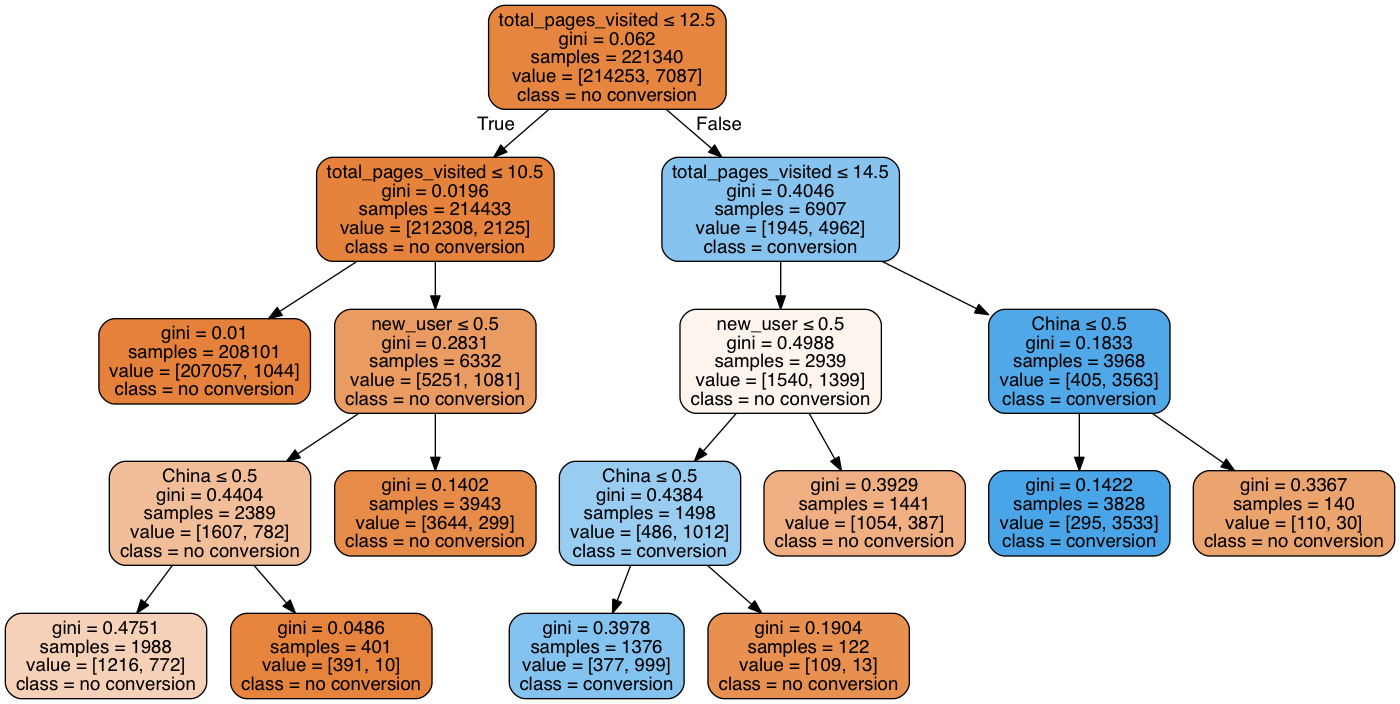

In [90]:
Image(graph.create_png())

#### Analyze graph:
The graph shows that if you're a returning user or you have seen more than 13 pages, it will result in a conversion. Otherwise, it will not. Also, if you having seen more than 13 pages and you are from China, this will  probably not result in a conversion.

From this graph, I can recommend the marketing group to increase visibility in China. The returning users from China all result in no recommendation regardless of the number of pages seen. Thus, one should increase the targeted campaigns towards Chinese users.

### Ensemble Methods
[Top](#Table-of-Contents)

#### Bagging
Takes the average of _B_ trees grown out of _B_ bootstrapped datasets. A bootstrapped dataset is subsampling with replacement from a single dataset. Bagging reduces the variance of the statistical method and thus improves the accuracy of the resulting classification.

In [99]:
run_model(BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20),
         max_features=.9, max_samples=0.9));


Training the model (Fitting to the training data) 
Fitted model: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=0.9, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
The accuracy for the decision tree classifier is 98.5494412818891


#### Random Forests
Setting $$max\space samples = \sqrt{total\space samples}$$ when bagging yields an optimum random forest model

**Finding the optimal subset of features to choose from**

In [93]:
from math import sqrt
sqrt(len(df)) / len(df)

0.0017783574850739467

In [102]:
run_model(RandomForestClassifier(
    n_estimators=100, max_leaf_nodes=20)
    );


Training the model (Fitting to the training data) 
Fitted model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The accuracy for the decision tree classifier is 98.4819734345351


## Summary
[Top](#Table-of-Contents)

From the baseline of 96.7%, I have improved the accuracy score by 1.85% to 98.55%. The Ensemble method of bagging many decision trees, using a 90% subsampling, resulted in the best result. The Random Forest did about the same at 98.48%.

As far as recommendations to the product team, I can see from both the descriptive stats and the decision tree that the more pages a user sees, the more likely he or she is to convert. From this we can recommend redesigning the page to encourage users to click around the site. 

Another area of improvement is improving the conversion rate of users in China. This insight surfaces in the decision tree plot. In both sides of the number of pages split, those in China tend to be non-converts. Perhaps the team could increase their digital marketing budget in China.